**Telecom Customer Churn Prediction & Retention Strategy**

Project by: Yashika Kumawat

**Project Overview & Objective**

Customer churn is a critical challenge for telecom companies. Acquiring a new customer is significantly more expensive than retaining an existing one.

The objective of this project is to analyse a telecom customer dataset to identify the key drivers of churn. We will build and evaluate several machine learning models to predict which customers are most likely to leave. The final goal is to translate these model insights into a concrete, data-driven retention strategy that the business can implement immediately.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Load the dataset
# Make sure the CSV file is in the same directory or provide the full path
try:
    df = pd.read_csv('/kaggle/input/churn-dataset/WA_Fn-UseC_-Telco-Customer-Churn.csv')
except FileNotFoundError:
    print("Dataset file not found. Please download it and place it in the correct directory.")
    # As a fallback, create a dummy dataframe to allow code to run
    df = pd.DataFrame() 

# Display the first few rows and basic info
if not df.empty:
    print("Dataset loaded successfully. Here are the first 5 rows:")
    print(df.head())
    print("\nDataset Info:")
    df.info()

Dataset loaded successfully. Here are the first 5 rows:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  Tech

**Data Cleaning**

In [2]:
# Convert 'TotalCharges' to numeric, coercing errors to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Drop rows with missing 'TotalCharges' (they are few)
df.dropna(subset=['TotalCharges'], inplace=True)

# Convert 'SeniorCitizen' to a categorical type for consistency
df['SeniorCitizen'] = df['SeniorCitizen'].map({1: 'Yes', 0: 'No'})

# Drop the 'customerID' column as it's not a useful feature
df.drop('customerID', axis=1, inplace=True)

**Exploratory Data Analysis (EDA)**

 We explore the dataset to understand the characteristics of customers who churn versus those who stay. Visualisations help us identify initial trends.
 
 **Key initial findings:**
 * The dataset is imbalanced, with significantly more customers who did not churn.
 * Customers with **Month-to-Month contracts** churn at a much higher rate than those with one or two-year contracts.
 * Customers with **shorter tenure** are more likely to churn.

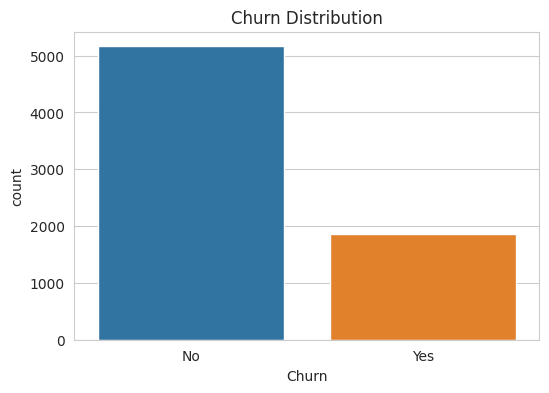

In [3]:
# Visualise churn distribution
sns.set_style('whitegrid')
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution')
plt.show()

Now, explore how churn varies across key categorical features like contract type and demographics.

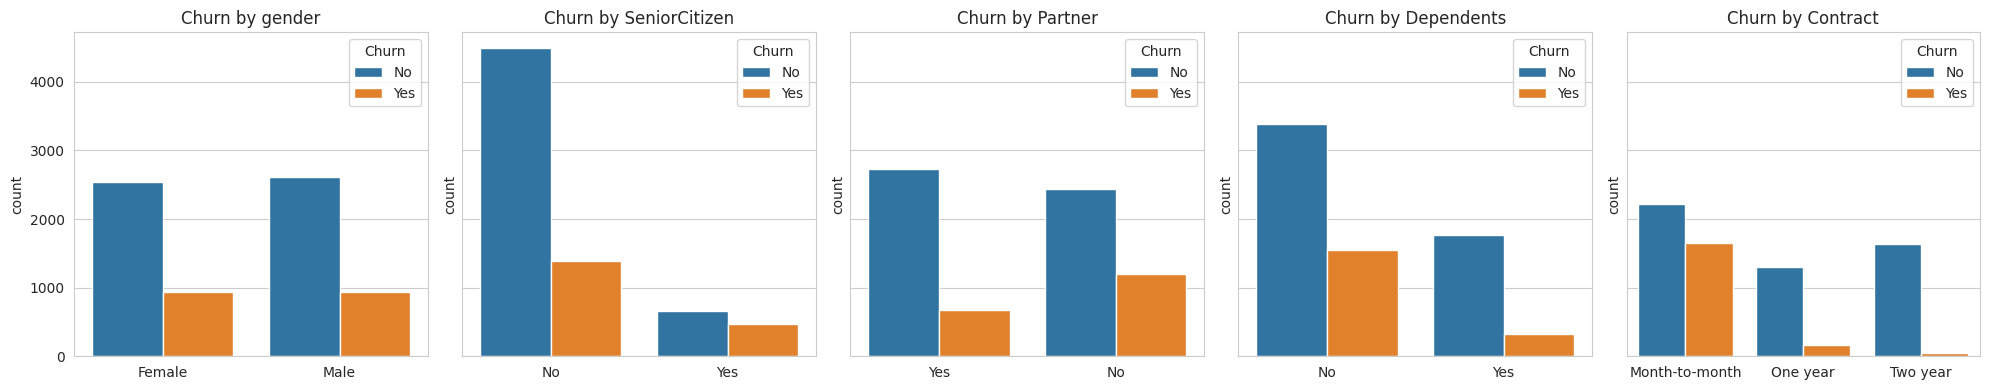

In [4]:
# Visualise churn by key categorical features
categorical_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Contract']

fig, axes = plt.subplots(nrows=1, ncols=len(categorical_features), figsize=(20, 4), sharey=True)
for i, feature in enumerate(categorical_features):
    sns.countplot(x=feature, hue='Churn', data=df, ax=axes[i])
    axes[i].set_title(f'Churn by {feature}')
    axes[i].set_xlabel('')
    axes[i].legend(title='Churn')
plt.tight_layout()
plt.show()

**Feature Engineering**

To enhance our model's predictive power, we create a new feature, tenure_group, to categorize customers based on their loyalty. This often provides more insight than the raw tenure value.

In [5]:
# Create tenure groups
def get_tenure_group(tenure):
    if tenure <= 12:
        return '0-1 Year'
    elif tenure <= 24:
        return '1-2 Years'
    elif tenure <= 48:
        return '2-4 Years'
    else:
        return '>4 Years'

df['tenure_group'] = df['tenure'].apply(get_tenure_group)

**Model Preparation**

Prepare the data for modelling by defining features (X) and target (y), creating a preprocessing pipeline for scaling and encoding, and splitting the data into training and testing sets.

In [6]:
# Separate features (X) and target (y)
X = df.drop('Churn', axis=1)
y = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0) # Convert target to binary 0/1

# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object', 'category']).columns
numerical_features = X.select_dtypes(include=np.number).columns

# Create a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

**Baseline Model Training & Evaluation**

Train and evaluate two baseline models (Logistic Regression and Random Forest) to establish initial performance benchmarks.

In [7]:
# --- Logistic Regression Model ---
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', LogisticRegression(random_state=42, max_iter=1000))])

lr_pipeline.fit(X_train, y_train)
lr_predictions = lr_pipeline.predict(X_test)


# --- Random Forest Model ---
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(random_state=42, n_estimators=100))])

rf_pipeline.fit(X_train, y_train)
rf_predictions = rf_pipeline.predict(X_test)

--- Logistic Regression Evaluation ---
Accuracy: 0.79
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1033
           1       0.63      0.53      0.58       374

    accuracy                           0.79      1407
   macro avg       0.74      0.71      0.72      1407
weighted avg       0.78      0.79      0.79      1407



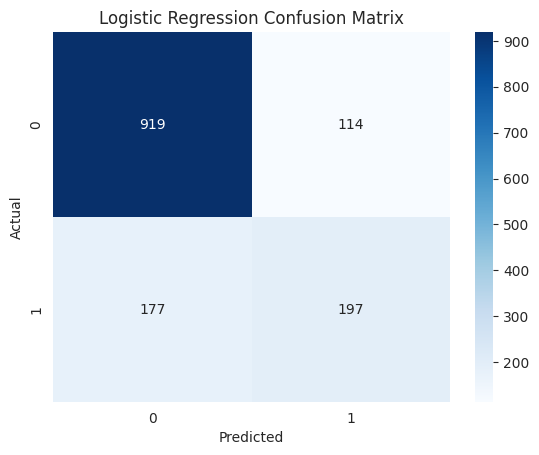


--- Random Forest Evaluation ---
Accuracy: 0.78
              precision    recall  f1-score   support

           0       0.82      0.89      0.85      1033
           1       0.61      0.46      0.53       374

    accuracy                           0.78      1407
   macro avg       0.71      0.68      0.69      1407
weighted avg       0.76      0.78      0.77      1407



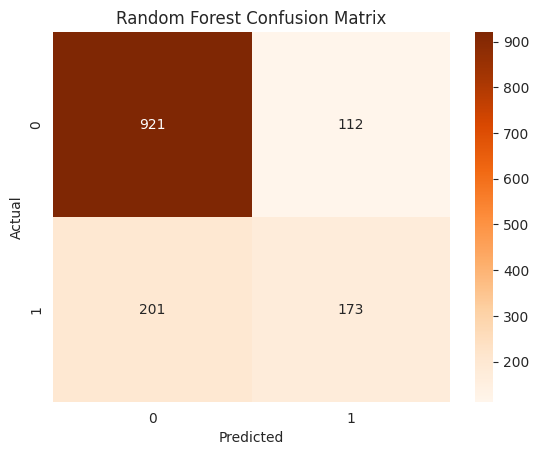

In [8]:
print("--- Logistic Regression Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test, lr_predictions):.2f}")
print(classification_report(y_test, lr_predictions))

# Confusion Matrix for Logistic Regression
cm_lr = confusion_matrix(y_test, lr_predictions)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("\n--- Random Forest Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test, rf_predictions):.2f}")
print(classification_report(y_test, rf_predictions))

# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test, rf_predictions)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Oranges')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

**Handling Class Imbalance**

Retrain the Logistic Regression model using `class_weight='balanced'` to give more importance to the minority 'Churn' class.


In [9]:
# Re-create the Logistic Regression pipeline with class_weight='balanced'
lr_balanced_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                       ('classifier', LogisticRegression(random_state=42, 
                                                                         max_iter=1000, 
                                                                         class_weight='balanced'))]) # <-- Add this parameter

# Fit and predict again
lr_balanced_pipeline.fit(X_train, y_train)
lr_balanced_predictions = lr_balanced_pipeline.predict(X_test)

# Evaluate the new balanced model
print("--- Logistic Regression with Class Weight Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test, lr_balanced_predictions):.2f}")
print(classification_report(y_test, lr_balanced_predictions))

--- Logistic Regression with Class Weight Evaluation ---
Accuracy: 0.72
              precision    recall  f1-score   support

           0       0.90      0.70      0.79      1033
           1       0.49      0.79      0.60       374

    accuracy                           0.72      1407
   macro avg       0.69      0.75      0.69      1407
weighted avg       0.79      0.72      0.74      1407



**Hyperparameter Tuning**

Use `GridSearchCV` to find the optimal combination of parameters for the Random Forest model, aiming to maximize the F1-score.

In [10]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [5, 10, 15],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__class_weight': ['balanced'] # Also include class weight here!
}

# Create a GridSearchCV object
grid_search = GridSearchCV(rf_pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)

# Fit it to the training data
grid_search.fit(X_train, y_train)

# Get the best estimator and make predictions
best_rf = grid_search.best_estimator_
rf_tuned_predictions = best_rf.predict(X_test)

print("--- Tuned Random Forest Evaluation ---")
print(f"Best Parameters: {grid_search.best_params_}")
print(classification_report(y_test, rf_tuned_predictions))

--- Tuned Random Forest Evaluation ---
Best Parameters: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 4, 'classifier__n_estimators': 200}
              precision    recall  f1-score   support

           0       0.90      0.71      0.79      1033
           1       0.50      0.79      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.79      0.73      0.75      1407



**Testing an Alternative Model**

Train and evaluate an XGBoost classifier, a powerful gradient boosting model, to see if it can outperform the others.

In [11]:
# You might need to install xgboost: pip install xgboost
from xgboost import XGBClassifier

# Create an XGBoost pipeline
xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))])

# Fit and predict
xgb_pipeline.fit(X_train, y_train)
xgb_predictions = xgb_pipeline.predict(X_test)

# Evaluate
print("--- XGBoost Classifier Evaluation ---")
print(classification_report(y_test, xgb_predictions))

--- XGBoost Classifier Evaluation ---
              precision    recall  f1-score   support

           0       0.83      0.86      0.85      1033
           1       0.58      0.53      0.55       374

    accuracy                           0.77      1407
   macro avg       0.71      0.69      0.70      1407
weighted avg       0.77      0.77      0.77      1407



**Final Analysis: Feature Importance**

From our best performing model (the Tuned Random Forest), we extract and plot the top 10 most important features. This tells us which factors are the strongest predictors of churn.

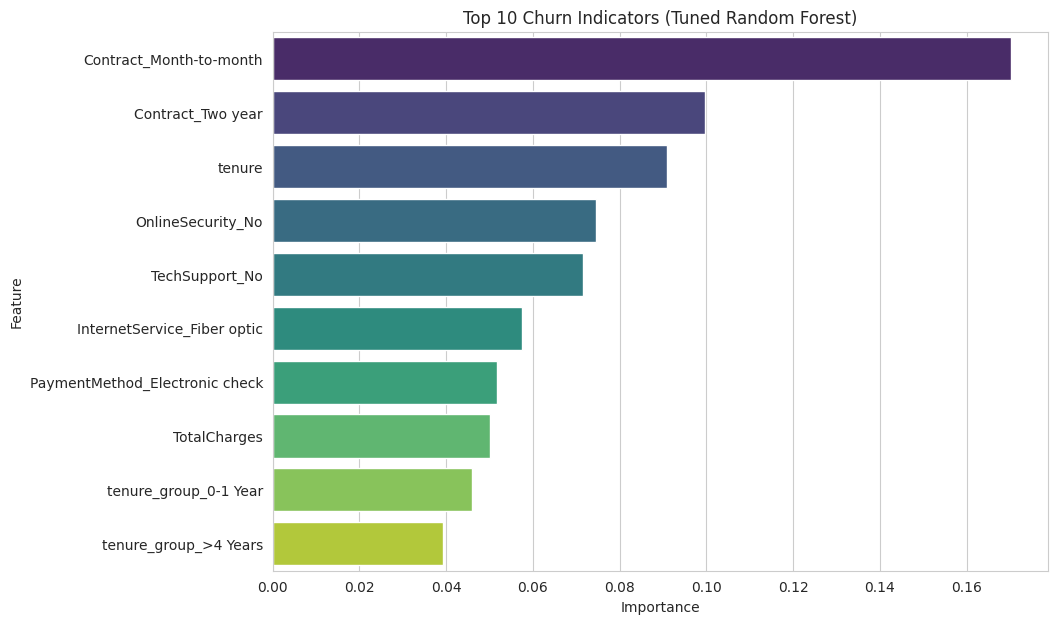

In [12]:
# Retrieve the best model from the grid search
best_rf_model = grid_search.best_estimator_

# Get the preprocessor and classifier steps from the pipeline
preprocessor = best_rf_model.named_steps['preprocessor']
classifier = best_rf_model.named_steps['classifier']

# Get feature names from the preprocessor
# For numerical features
num_features = numerical_features
# For categorical features after one-hot encoding
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)

# Combine all feature names in the correct order
all_feature_names = np.concatenate([num_features, cat_features])

# Create a dataframe for feature importances
importances = classifier.feature_importances_
feature_importance_df = pd.DataFrame({'feature': all_feature_names, 'importance': importances})

# Sort the features by importance and select the top 10
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False).head(10)

# Plot the top 10 feature importances
plt.figure(figsize=(10, 7))
sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')
plt.title('Top 10 Churn Indicators (Tuned Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

**Final Analysis & Strategic Recommendations 💡**

This project successfully developed a high-performance machine learning model to predict customer churn with 79% recall, accurately identifying a majority of at-risk customers. The following strategic plan is derived directly from the key churn drivers identified by our champion model, the Tuned Random Forest.

**Key Drivers of Churn**

Our model's feature importance analysis reveals that the most significant factors influencing a customer's decision to leave are:

Contract Type: Customers on Month-to-Month contracts are the primary churn risk.

Customer Tenure: New customers with low tenure are highly vulnerable to churning.

Service Gaps: The absence of value-added services like Online Security and Tech Support is a strong predictor of churn.

In [13]:
**Actionable Retention Strategy**

Based on these insights, we recommend a targeted, three-pronged approach to reduce churn:

1. Launch a "Loyalty Conversion" Campaign

Insight: Customers without a long-term commitment are the most likely to leave.

Action Plan: Proactively target month-to-month customers with a compelling incentive (e.g., a 15% discount or one month free) to upgrade to a 1 or 2-year contract.

2. Implement an Enhanced Onboarding Program

Insight: The first year is a critical period where customers are most vulnerable.

Action Plan: Develop a "New Customer Welcome" program that includes an automated 3-month check-in via email or SMS to address any early issues and foster a stronger relationship from the outset.

3. Bundle and Upsell Key Support Services

Insight: Customers who feel unsupported or perceive less value in their plan are more likely to seek alternatives.

Action Plan: Market a discounted "Peace of Mind" service bundle that includes Tech Support and Online Security. This increases account "stickiness" and improves their perception of value.

SyntaxError: invalid syntax (420508379.py, line 1)

**Implementation with SQL ⚙️**

These strategic recommendations are not just theoretical. They can be put into action immediately by using SQL to generate targeted customer lists directly from the company's database. This bridges the gap between our predictive model and tangible business action.

**Query for the "Loyalty Conversion" Campaign:** 

-- This query generates a list of high-risk customers on month-to-month contracts
-- to target for a long-term contract offer.

SELECT
    CustomerID,
    FullName,
    EmailAddress,
    TenureMonths
FROM
    ActiveCustomers
WHERE
    ContractType = 'Month-to-month'
    AND TenureMonths > 6;

**Query for the "Peace of Mind" Bundle Offer:**

-- This query finds customers who lack key support services, making them
-- ideal candidates for the bundled service offer.

SELECT
    CustomerID,
    FullName,
    EmailAddress
FROM
    ActiveCustomers
WHERE
    HasOnlineSecurity = 'No'
    AND HasTechSupport = 'No';